# Analyze the gamma rule

## Defining the Surrogate model for the gamma rule

### Linear layer

We look at the simple case of a linear model, that shares its parameters in every layer. 
We have a matrix $A^{(t)} \in \mathbb{R}^{n \times n}$ and define

$$ h^{(0)} = x_0 $$
$$ h^{(t)} = A^{(t)} h^{(t-1)} $$

for some initialization $x_0 \in \mathbb{R}^{n}$.
Instead of the intuitive surrogate model with $R^+_{\cdot | \cdot}(t) = A^{(t)}$,
we would now like to define an alternative surrogate model, that constructs the same layerwise activations $ R^+_{\cdot}(t) $ but with different transition coefficients $R^+_{j | i}(t)$.

**Forward surrogate model.** 
We choose a $\gamma \in \mathbb{R}^+$, and abbreviate $w_{j, i} = A^{(t)}_{j, i}$ for the current layer $t$.
$w_{j | i}^+$ is the positive part of the weights $w_{j | i}$.

$$ R^+(0) = x_0 $$
$$ R^+_{j | i}(t) = (w_{j | i} + \gamma \cdot w_{j | i}^+) \cdot c_j $$
$$ c_j = \frac{ \sum_i R^+_{i}(t-1) w_{j | i} }{ \sum_i R^+_{i}(t-1) (w_{j | i} + \gamma \cdot w_{j | i}^+) } $$

where $c_j \in [0, 1]$ is a scaling factor per output neuron $j$.

**Surrogate model check** We want to check, how good the surrogate model recovers the original mode, we want to show that $R^+(t) = h(t)$.

*Proof.* We show by induction, starting with $t = 0$. By definition,

$$ R^+(0) = x_0 = h^{(0)} $$

Now, in the induction step $t \rightarrow t+1$, we assume $ R^+(t-1) = h^{(t-1)}$, then

\begin{align*}
R^+_{j}(t) 
&= \sum_i R^+_{j | i}(t) \cdot R^+_{i}(t-1) \\
&= \sum_i R^+_{i}(t-1) \cdot (w_{j | i} + \gamma \cdot w_{j | i}^+) \cdot c_j \\
&= c_j  \cdot \sum_i R^+_{i}(t-1) \cdot (w_{j | i} + \gamma \cdot w_{j | i}^+) \\
&= \frac{ \sum_i R^+_{i}(t-1) w_{j | i} }{ \sum_i R^+_{i}(t-1) (w_{j | i} + \gamma \cdot w_{j | i}^+) }
         \cdot \sum_i R^+_{i}(t-1) \cdot (w_{j | i} + \gamma \cdot w_{j | i}^+) \\
&= \sum_i R^+_{i}(t-1) w_{j | i} \\
&= \sum_i h^{(t-1)} w_{j | i} \\
&= h^{(t)} \\
\end{align*}

**Backward surrogate model.**
For the backward chain we have 

\begin{align*}
R^-_{i}(t-1) 
&= \sum_j \frac{ R^+_{j | i}(t) \cdot R^+_{i}(t-1) }
                { \sum_{i'} R^+_{j | i'}(t) \cdot R^+_{i'}(t-1)} 
            R^-_{j}(t) \\
&= \sum_j \frac{ (w_{j | i} + \gamma \cdot w_{j | i}^+) \cdot c_j \cdot h_{i}^{(t-1)} }
                { \sum_{i'} (w_{j | i'} + \gamma \cdot w_{j | i'}^+) \cdot c_j \cdot h_{i'}^{(t-1)} } 
            R^-_{j}(t) \\
&= \sum_j \frac{ (w_{j | i} + \gamma \cdot w_{j | i}^+) \cdot h_{i}^{(t-1)} }
                { \sum_{i'} (w_{j | i'} + \gamma \cdot w_{j | i'}^+) \cdot h_{i'}^{(t-1)} } 
            R^-_{j}(t) \\
\end{align*}

which is known as the LRP-$\gamma$ rule.

## Empirical analysis of LRP-$\gamma$'s forward surrogate model

We now analyse the Eigenvalues of the LRP-$\gamma$'s forward surrogate model for the following cases:

- a random 3x3 matrix
    - with random 3-dimensional input
- a random 784x784 matrix 
    - with random 784-dimensional input
- a 784x784 matrix that represents a learned convolution operation: It performs the global transition from a (flattened) MNIST picture, to a first layer hidden representation of a convolutional network (before nonlinearities)
    - with an MNIST picture, flattened to a 784-dimensional vector
    - with random 784-dimensional input

#### Loading stuff

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from util.util_cnn import get_test_loader, CNN, test
device = "cpu"
PATH = './models/mnist_cnn.torch'

from util.util_gamma_rule import forw_surrogate_matrix, run_and_plot

import numpy as np
import matplotlib.pyplot as plt

/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### One random matrix, creating  $\gamma$ Forward Surrogate model wrt. five random data points

#### Findings
The most interesting phenomena on these simple random 3D matrices is:
The first and second largest abs(complex Eigenvalues) are equal for some sections of $\gamma$.
This can be seen well, where the orange and blue lines overlap in the below plots.

The reason for this is so far unclear.

In [2]:
global_seed = 100

# define experiment
shape = (3,3) # (out_dim, in_dim) <-- keep the matrix quadratic for now, as we use eigenvalue analysis
n_points = 5
n_experiments = 3
n_gammas = 501
gammas = np.linspace(0,20, n_gammas)

# mean & standard deviation
points_params = (0, 1)
weights_params = (0, .5)

# generate random datapoints
np.random.seed(1 + global_seed)
points_list = np.random.normal(*points_params, size = (n_points, shape[1]))

# generate random weights matrixes
np.random.seed(2 + global_seed)
weights_list = np.random.normal(*weights_params, size = (n_experiments, *shape))

Matrix 1, Point 1: 3 of 3 Eigenvalues are non-zero. 3 get plotted.
Matrix 1, Point 2: 3 of 3 Eigenvalues are non-zero. 3 get plotted.
Matrix 1, Point 3: 3 of 3 Eigenvalues are non-zero. 3 get plotted.
Matrix 1, Point 4: 3 of 3 Eigenvalues are non-zero. 3 get plotted.
Matrix 1, Point 5: 3 of 3 Eigenvalues are non-zero. 3 get plotted.


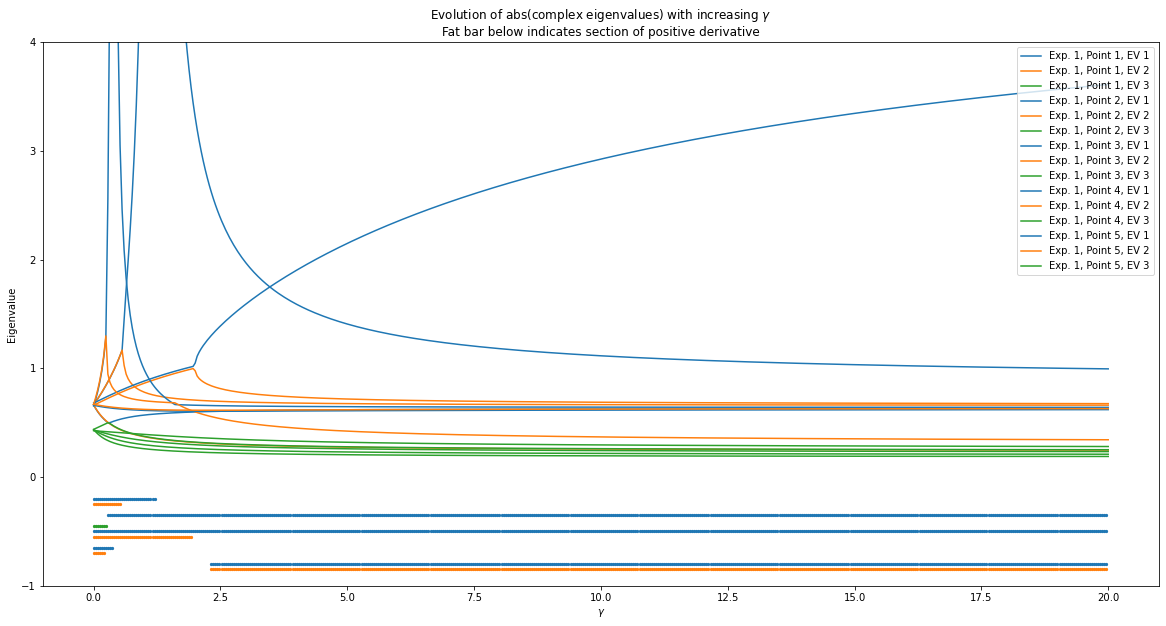

In [3]:
run_and_plot(weights_list[:1], points_list, gammas, one_plot_per_point=False)

### Preparing a real, learned transition matrix (MNIST)

#### Loading stuff

In [4]:
model = CNN().to(device)
model.load_state_dict(torch.load(PATH))

test(model, device, get_test_loader())

/Users/johannes/Repositories/Masterarbeit/util/util_cnn.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.0926, Accuracy: 9733/10000 (97%)



0 torch.Size([1024, 1, 28, 28]) torch.Size([1024])
tensor([[1.9122e-14, 1.8859e-16, 1.0266e-12, 2.6480e-13, 1.0000e+00, 1.1667e-11,
         8.9874e-08, 1.7965e-15, 7.0549e-13, 3.2604e-08]],
       grad_fn=<ExpBackward0>)


/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


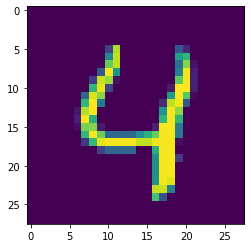

In [5]:
test_loader = get_test_loader(False)

for i, (data, target) in enumerate(test_loader):
    print(i, data.shape, target.shape)
    
    x = data[4]
    plt.imshow(x[0])
    print(model(x).exp())
    
    break

#### Lets express a single (learned) convolutional filter in the form of a global transition matrix

- input dimension is 28x28 = 784
- output dimension is 24x24 = 576
- transition matrix shape is (576, 784)
- (no padding is used)

input: (28, 28)


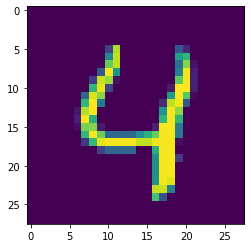

output: (24, 24)


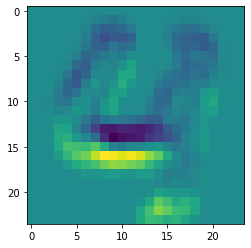

In [6]:
inp = x[0].detach().numpy()

print(f'input: {inp.shape}')
plt.imshow(inp)
plt.show()

out_org = model.conv1(x)[0].detach().numpy()
print(f'output: {out_org.shape}')
plt.imshow(out_org);

In [97]:
def global_conv_matrix(conv, bias=None, img_shape=None, zero_padding=(0,0)):
    assert(img_shape and len(img_shape) == len(zero_padding))
    img_shape = np.array(img_shape)
    zero_padding = np.array(zero_padding)
    if bias: print("Warning: So far we currently do nothing with passed bias terms.")

    # this is the matrix that will represent the global convolution operation
    img_shape_padded = img_shape + 2*zero_padding
    img_flattened_length = np.prod(img_shape_padded)

    res_shape = img_shape_padded - conv.shape + 1
    res_flattened_length = np.prod(res_shape)
    
    print(img_shape_padded, img_flattened_length, res_shape, res_flattened_length, )

    # this is gonna be the global convolution matrix
    trans = np.zeros((res_flattened_length, img_flattened_length))

    # application positions of conv: this relates to the index where the top left corner of the conv sits in the padded input, at the application of the filter.
    img_positions = np.mgrid[0:res_shape[0], 0:res_shape[1]]
    img_positions = np.transpose(img_positions, (1,2,0)).reshape((-1,2))
    print(img_positions.max(axis=0), img_positions.shape)

    # distinct position in conv filter
    conv_positions = np.mgrid[0:conv.shape[0], 0:conv.shape[1]]
    conv_positions = np.transpose(conv_positions, (1,2,0)).reshape((-1,2))

    print(img_shape, img_shape_padded, res_shape)

    # Write convolutional weights in many places of the global transition matrix
    for i, conv_pos in enumerate(conv_positions):
        # which weight of the conv to write?
        val = conv[conv_pos[0], conv_pos[1]]
        
        # calc all 576 places to write to
        x_indices = np.arange(res_flattened_length)
        y_indices = np.ravel_multi_index((img_positions + conv_pos).T, img_shape_padded)
        
        # write
        trans[x_indices, y_indices] = val

    # delete columns of trans matrix that are associated with padding. make trans square again.
    mask = np.ones(img_flattened_length)
    ara = np.arange(img_flattened_length)
    # exclude all those img_positions that lie in the padded rows (the first two, and the last two).
    mask[ara < img_shape_padded[1] * zero_padding[0]] = False
    mask[ara >= len(mask) - img_shape_padded[1] * zero_padding[0]] = False 
    # exclude all those that are applied in the first rows, and last rows, that are just zero padding
    mask[np.mod(ara,                   img_shape_padded[1]) < zero_padding[1]] = False
    mask[np.mod(ara + zero_padding[1], img_shape_padded[1]) < zero_padding[1]] = False

    trans = trans[:, mask != 0]
    return trans

trans = global_conv_matrix(conv = model.conv1.weight.detach().numpy()[0,0],
                            bias = model.conv1.bias.detach().numpy()[0],
                            img_shape=inp.shape,
                            zero_padding=(0,0))

trans.shape

[28 28] 784 [24 24] 576
[23 23] (576, 2)
[28 28] [28 28] [24 24]


(576, 784)

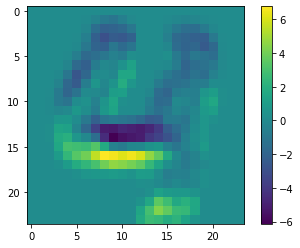

In [14]:
# check that the transition matrix gives the same result as the convolution operation;
out = trans @ inp.flatten()
out = out.reshape((24,24))
plt.colorbar(plt.imshow(out))
assert(np.allclose(out + bias, out_org, atol=0.00001))

In [15]:
# lets make the global transition matrix quadratic by adding some rows of zero
# (this will not change eigenvalues, only add some that are always zero)

trans_prime = np.vstack((trans, np.zeros((trans.shape[1]-trans.shape[0], trans.shape[1]))))
trans_prime.shape

(784, 784)

#### Simple analysis of trans_prime

### [Learned Convolution Matrix, Random Matrix] - Random points

#### Findings

- learned weights only have 24 non-zero Eigenvalues.
- EV of random matrix change much more erratic than those of the learned weights.

trans_prime has by construction only 25 non-null entries per row. The structure is a sort of block-diagonal.
(array([ 0, 25]), array([208, 576]))


Text(0.5, 1.0, 'trans_prime values')

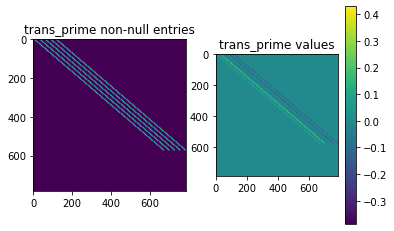

In [39]:
print("trans_prime has by construction only 25 non-null entries per row. The structure is a sort of block-diagonal.")
print(np.unique((trans_prime != 0).sum(axis=1), return_counts=True))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(trans_prime != 0)
plt.colorbar(ax2.imshow(trans_prime))

ax1.set_title("trans_prime non-null entries")
ax2.set_title("trans_prime values")

#### EV plot

In [40]:
global_seed = 100

# define experiment
n_points = 1
n_gammas = 501
gammas = np.linspace(0, 20, n_gammas)

# mean & standard deviation
points_params = (0, 1)

# generate random datapoints
np.random.seed(1 + global_seed)
points_list = np.random.normal(*points_params, size = (n_points, trans_prime.shape[1]))

In [41]:
big_random_matrix = np.random.normal(*weights_params, size=trans_prime.shape) # random matrix of same shape as trans_prime
big_random_matrix_w_zeros = big_random_matrix                       
big_random_matrix_w_zeros[trans.shape[1]-trans.shape[0]:] = 0                 # matrix where last rows are zero (like trans_prime)

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 1: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


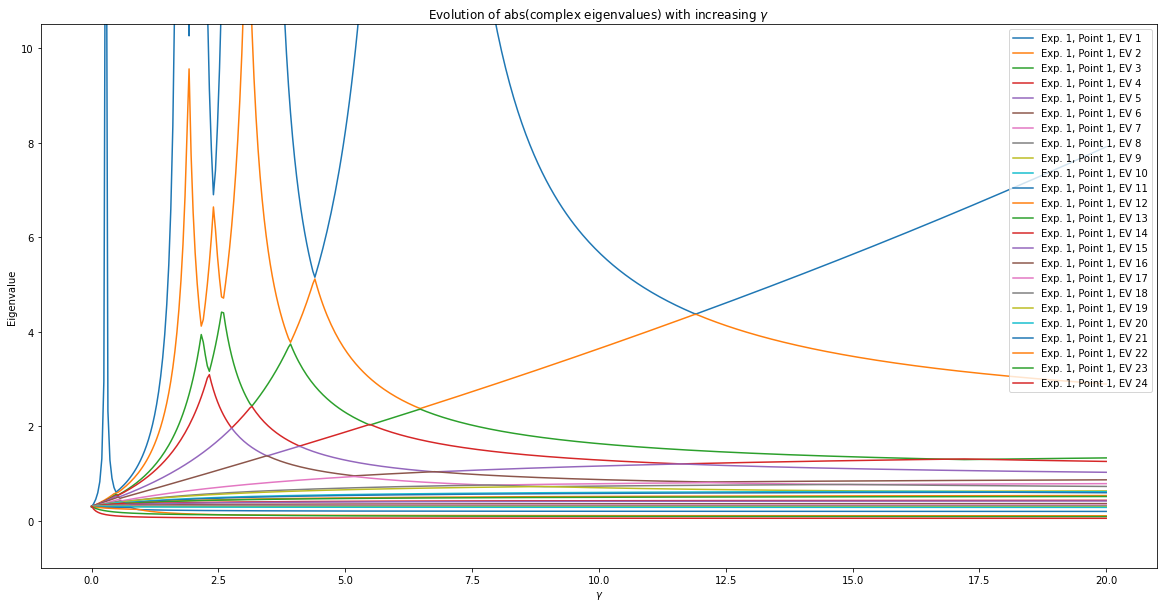

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 2, Point 1: 208 of 208 Eigenvalues are non-zero. 24 get plotted.


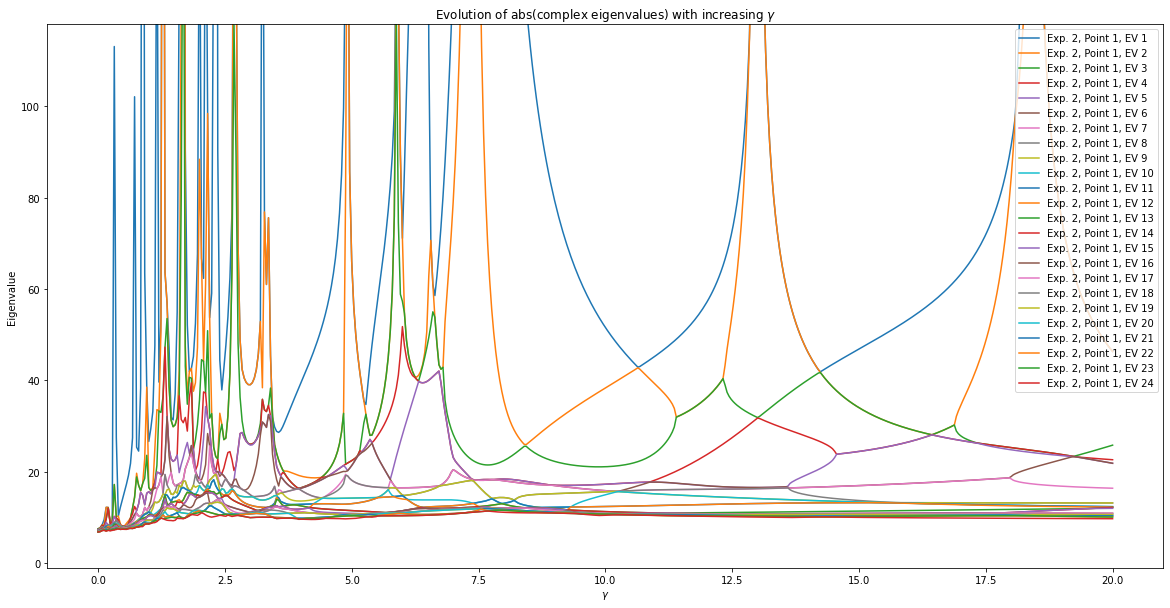

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 1: 208 of 208 Eigenvalues are non-zero. 208 get plotted.


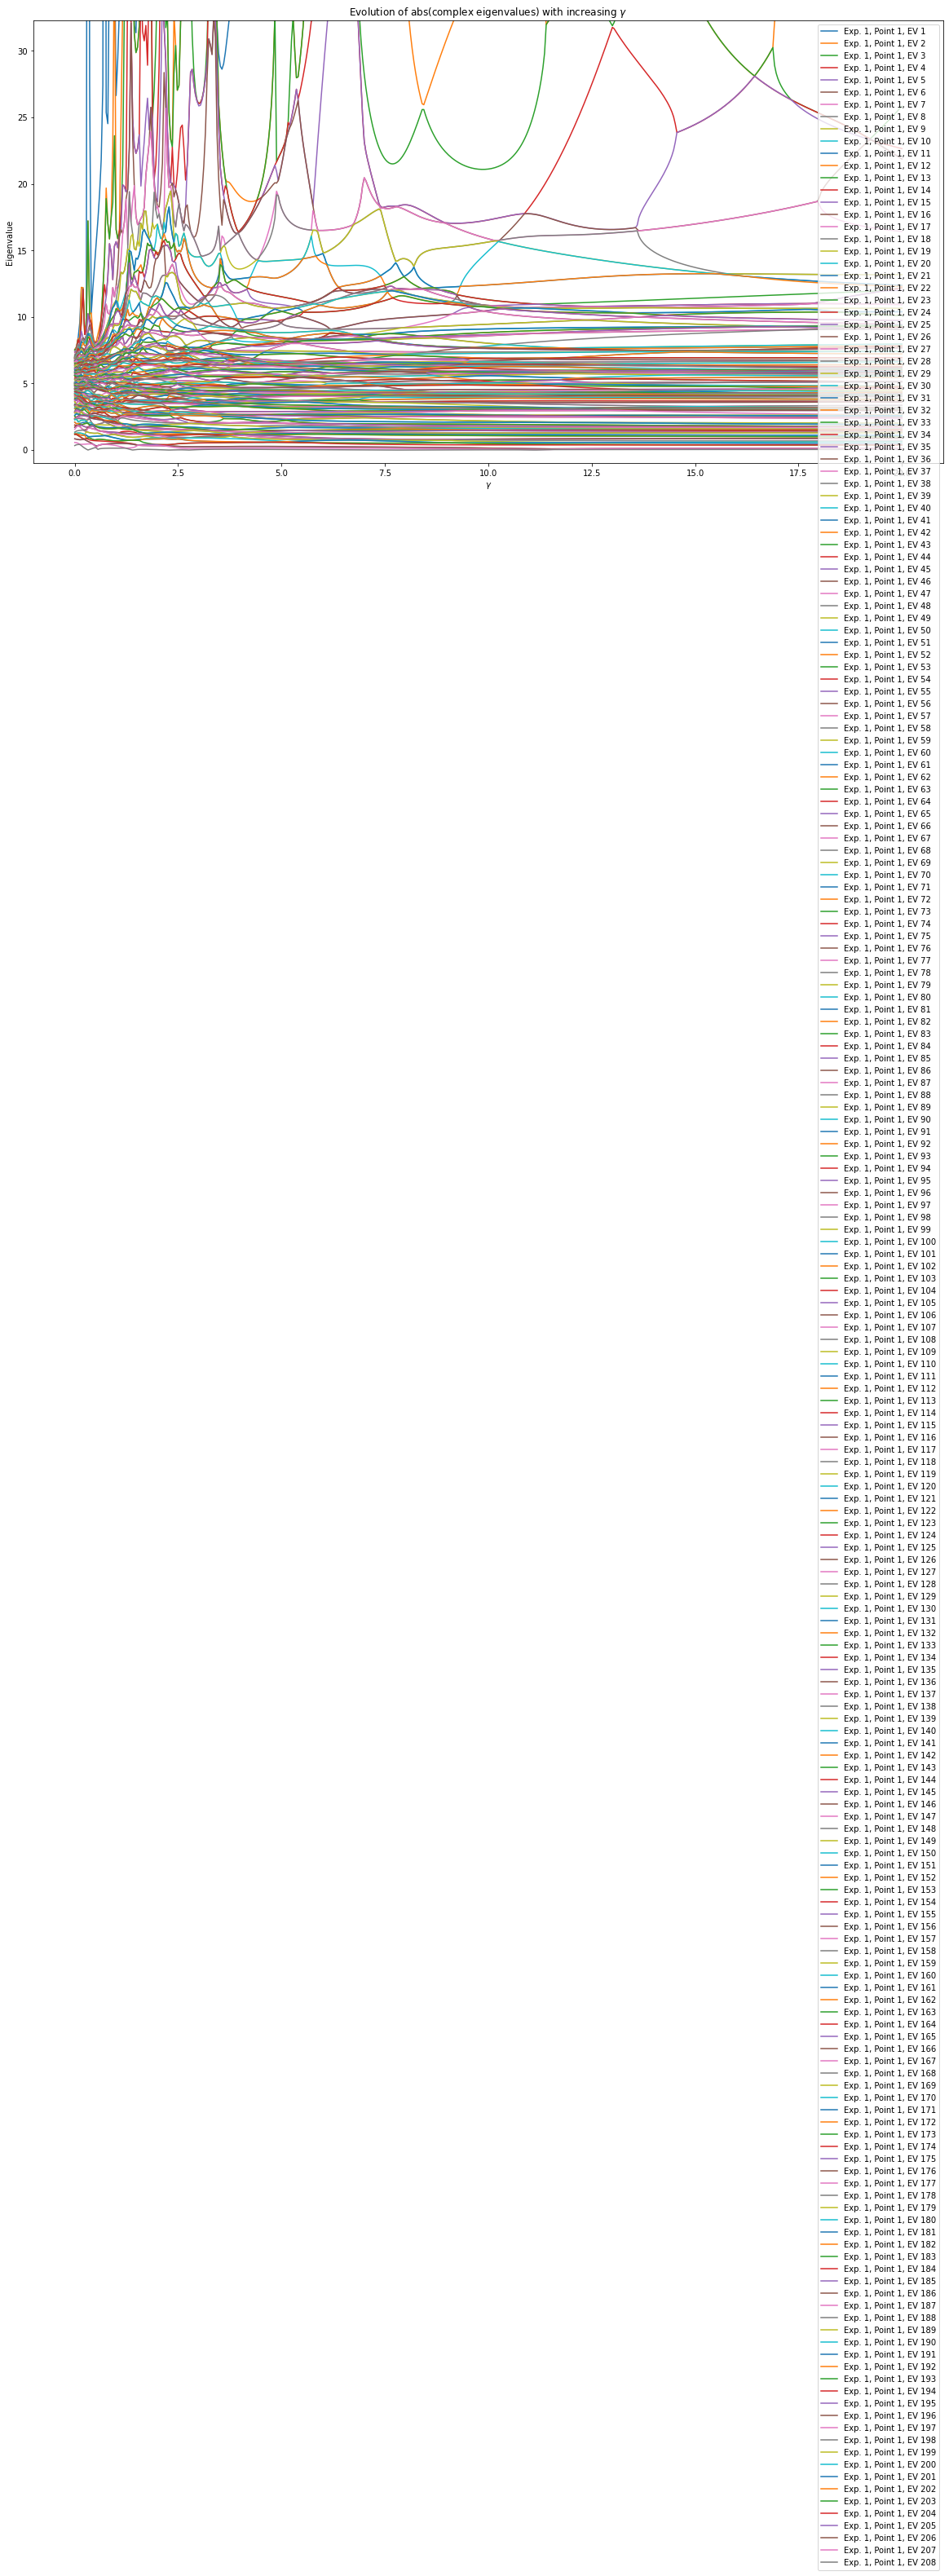

In [42]:
# at first we plot the top 24 EVs of the real transition matrix and of the random 784*784 matrix.
# then we plot all 784 EVs of the random matrix.

run_and_plot([trans_prime, big_random_matrix_w_zeros], points_list, gammas, mark_positive_slope=False, percentile_to_plot=99, num_evals=24)
run_and_plot([big_random_matrix_w_zeros], points_list, gammas, mark_positive_slope=False, percentile_to_plot=99)

#### Highlight one EV discontinuity

-> For some values of Gamma an Eigenvalue diverges.

(784,)


/Users/johannes/Repositories/Masterarbeit/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


24 of 784 are non-zero and get plotted.
(100, 24)
(100, 1)


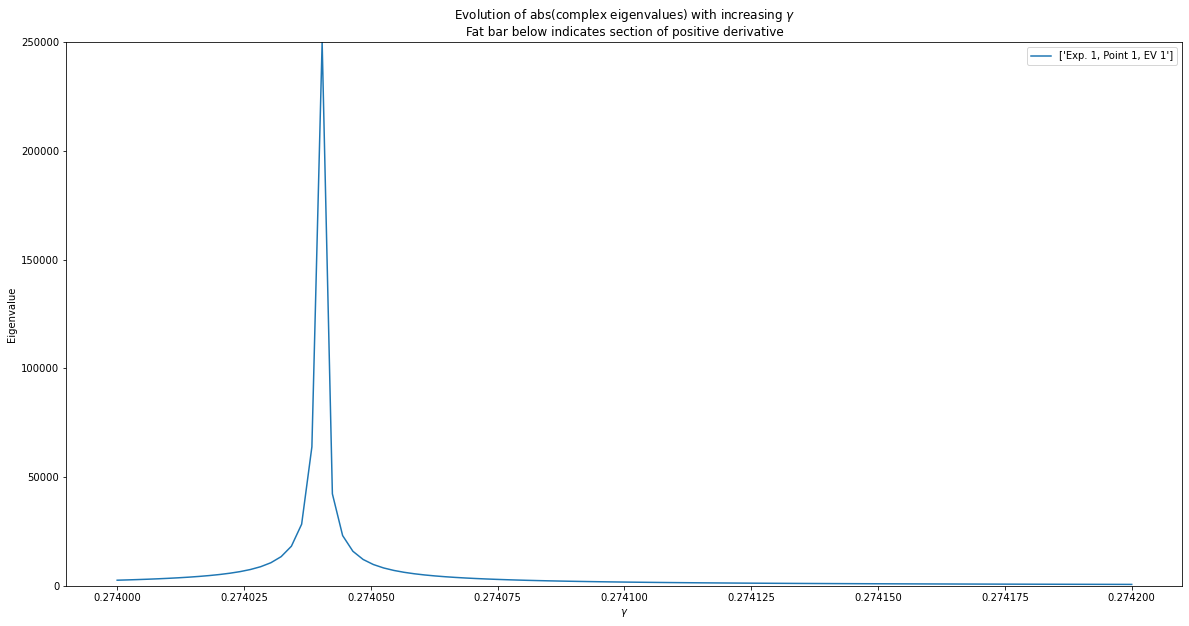

In [81]:
run_and_plot([trans_prime], 
            points_list=np.random.normal(*(0, 1), size = (1, trans_prime.shape[1])), 
            gammas=np.linspace(.274, .2742, 100), 
            num_evals=1, mark_positive_slope=False, percentile_to_plot=100)

### [Learned Convolution Matrix, Random Matrix] - Real data points / MNIST pictures

#### Findings

- with real (learned not random) transitions **and** real datapoints, the EV develop very smoothly
- the general trend is that **with higher gamma, fewer EV have a high activation**.

In [44]:
n_points = 3

real_points_list = data.flatten(1,3).detach().numpy()
print(real_points_list.shape)
print(real_points_list[:n_points].shape)

(1024, 784)
(3, 784)


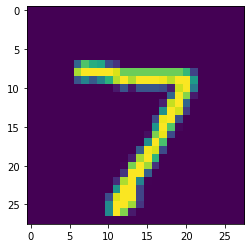

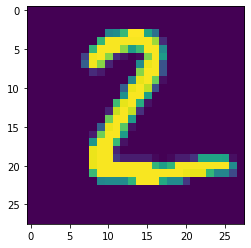

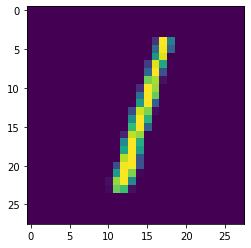

In [45]:
for i in range(n_points):
    plt.imshow(data[i].detach().numpy()[0])
    plt.show()

#### Gamma in [0, 20]

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 1: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


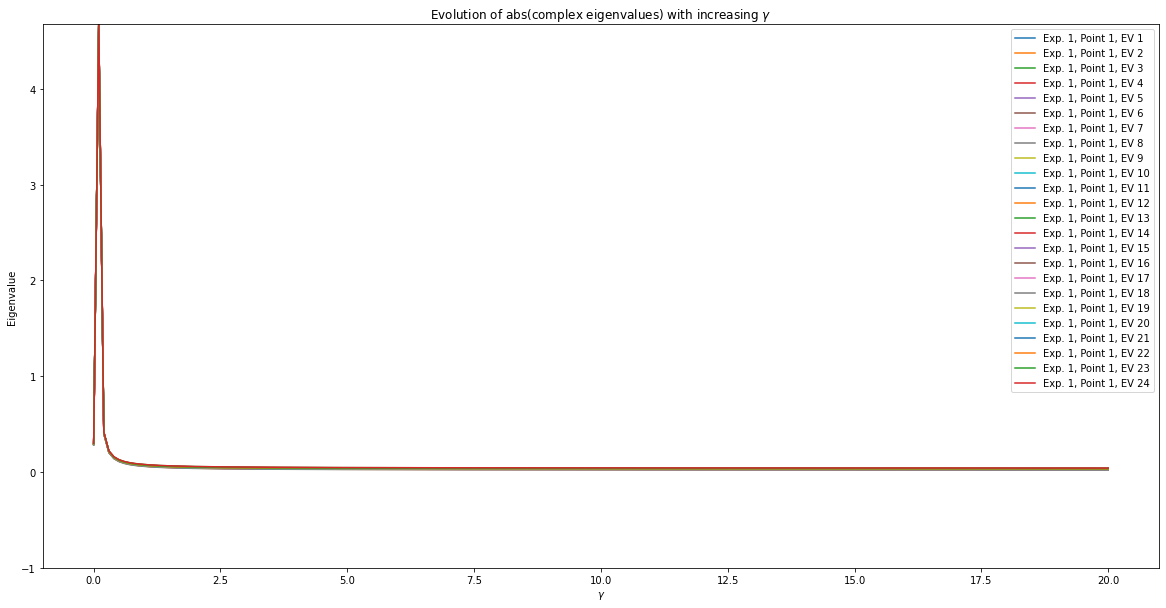

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 2: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


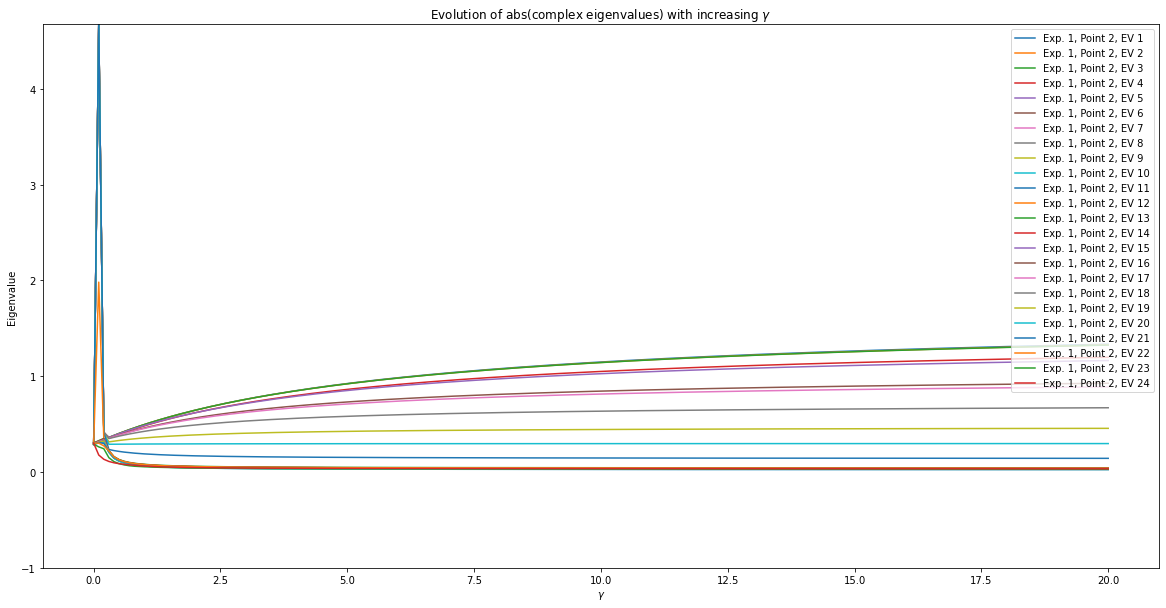

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 3: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


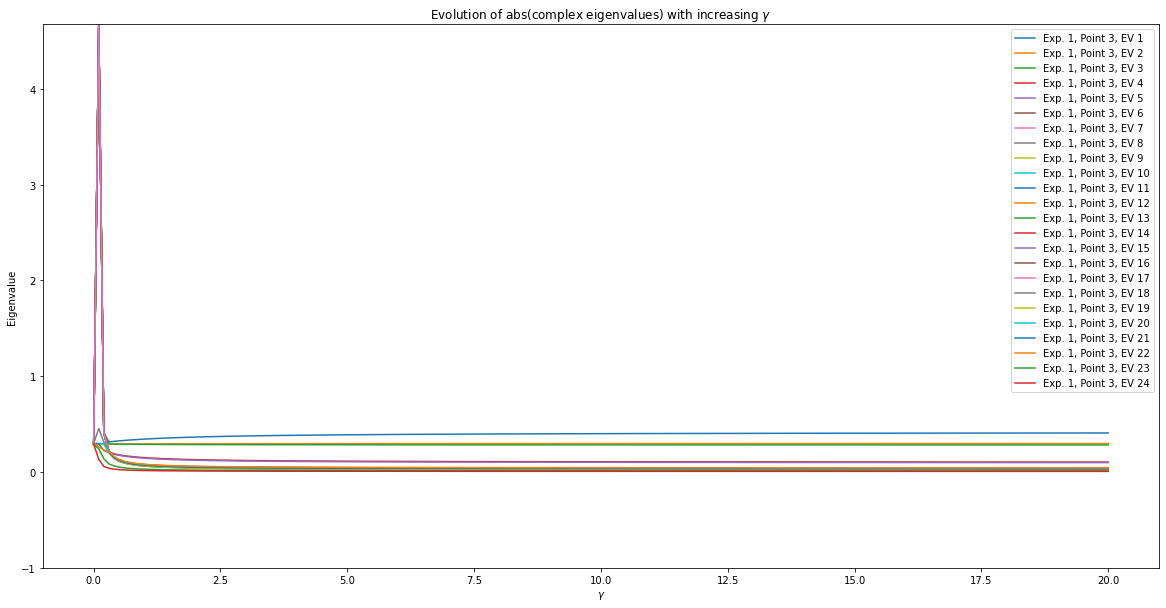

In [46]:
run_and_plot([trans_prime], points_list=real_points_list[:n_points], gammas=np.linspace(0, 20, 201), mark_positive_slope=False, percentile_to_plot=99.99, num_evals=24, one_plot_per_point=True)

#### Gamma in [0, 5]

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 1: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


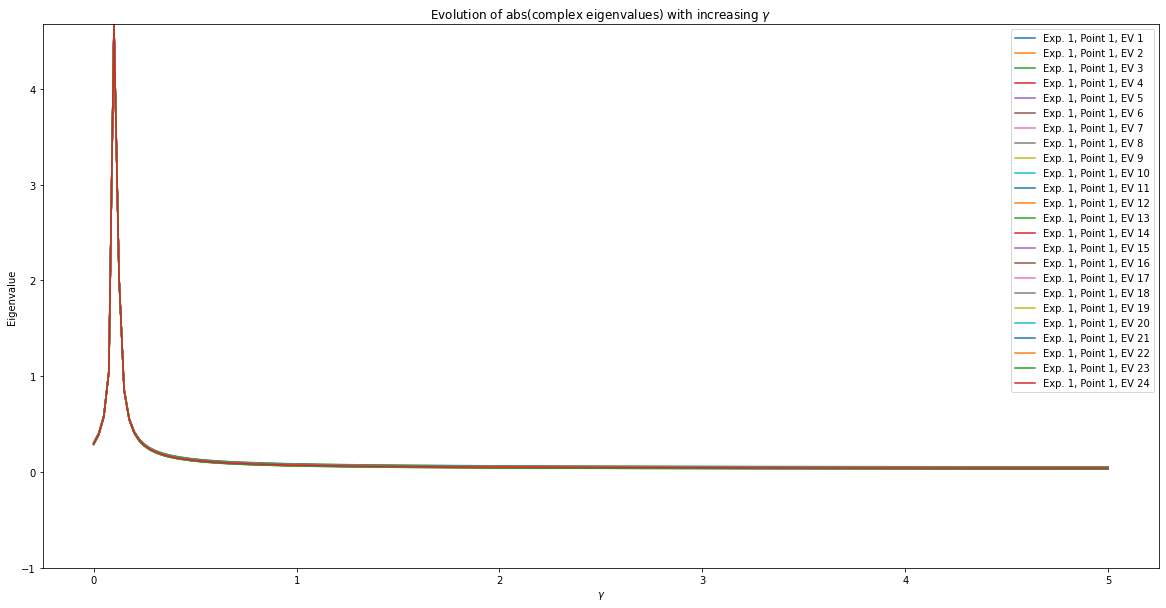

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 2: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


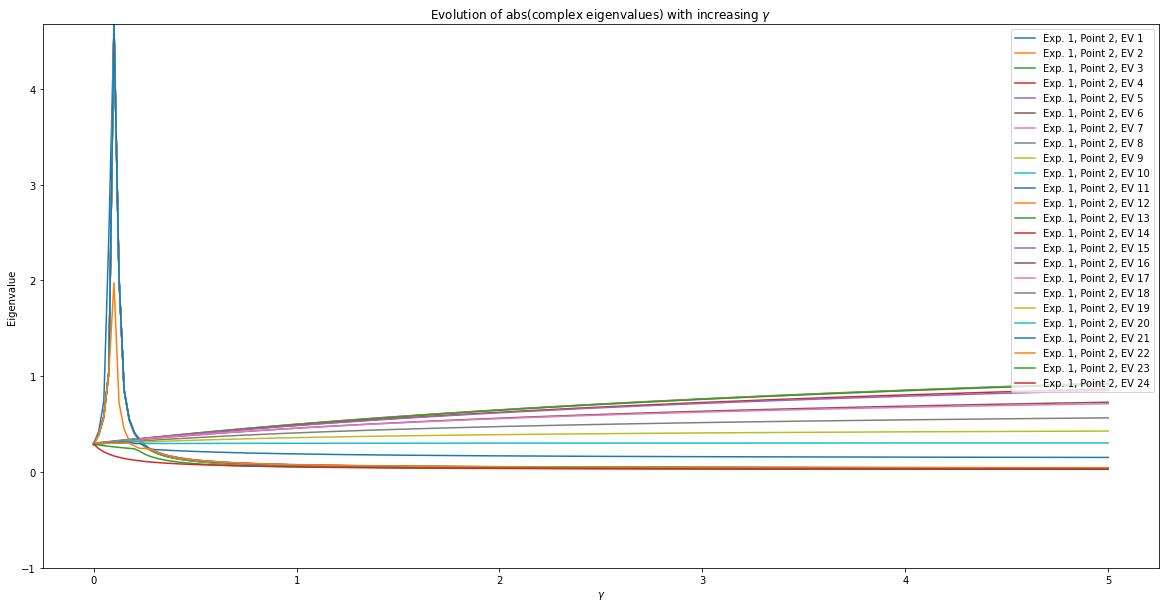

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 3: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


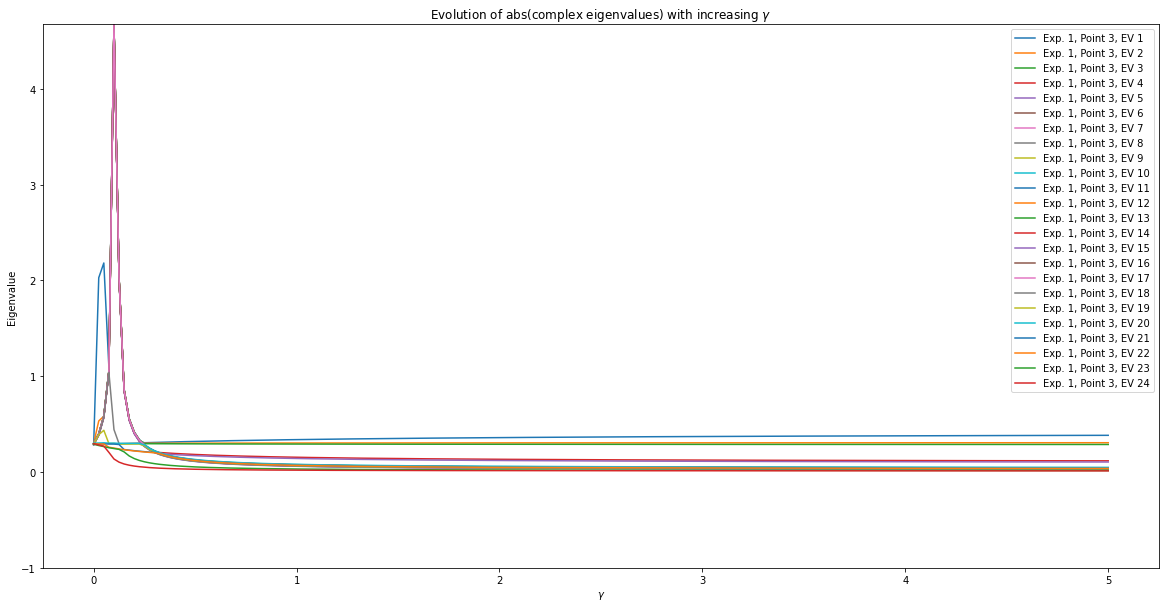

In [47]:
run_and_plot([trans_prime], points_list=real_points_list[:n_points], gammas=np.linspace(0, 5, 201), mark_positive_slope=False, percentile_to_plot=99.99, num_evals=24, one_plot_per_point=True)

#### Gamma in [0, 0.3]

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 1: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


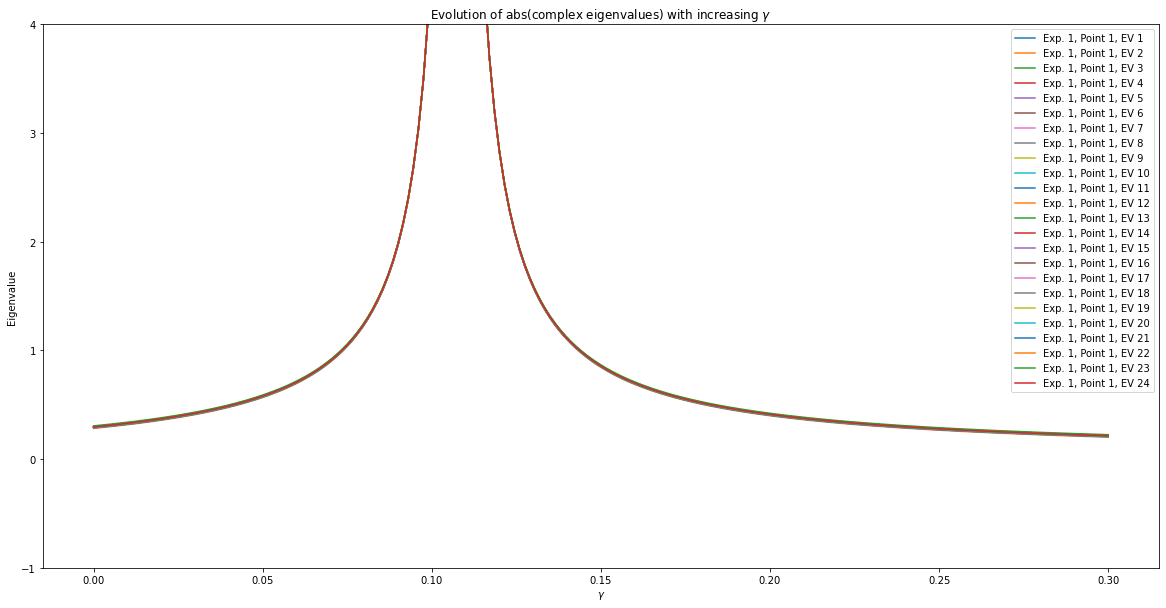

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 2: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


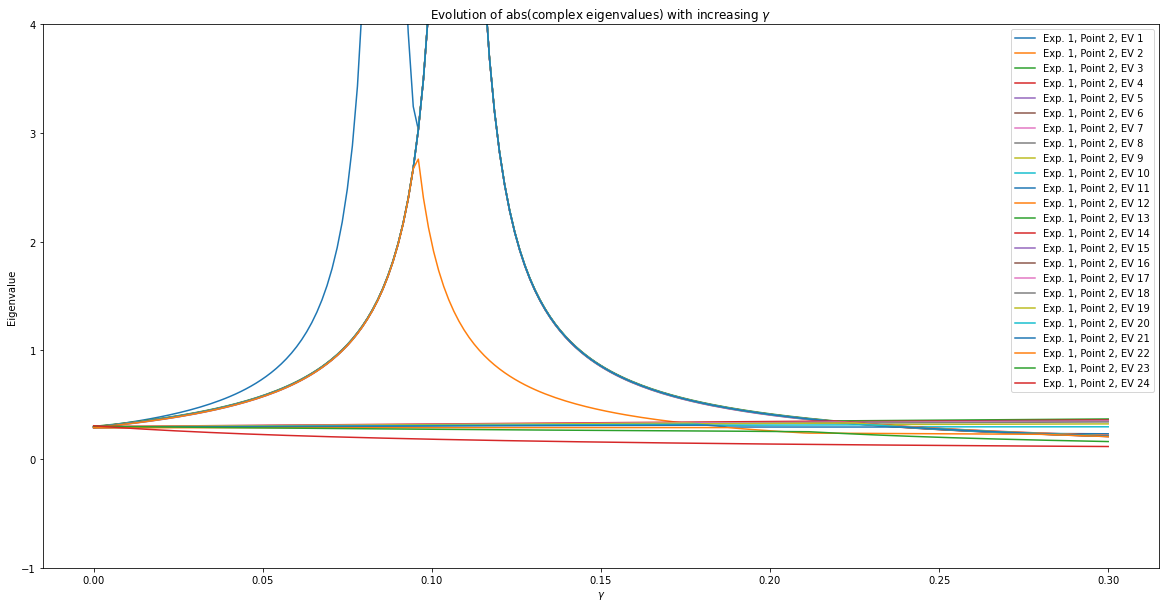

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 3: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


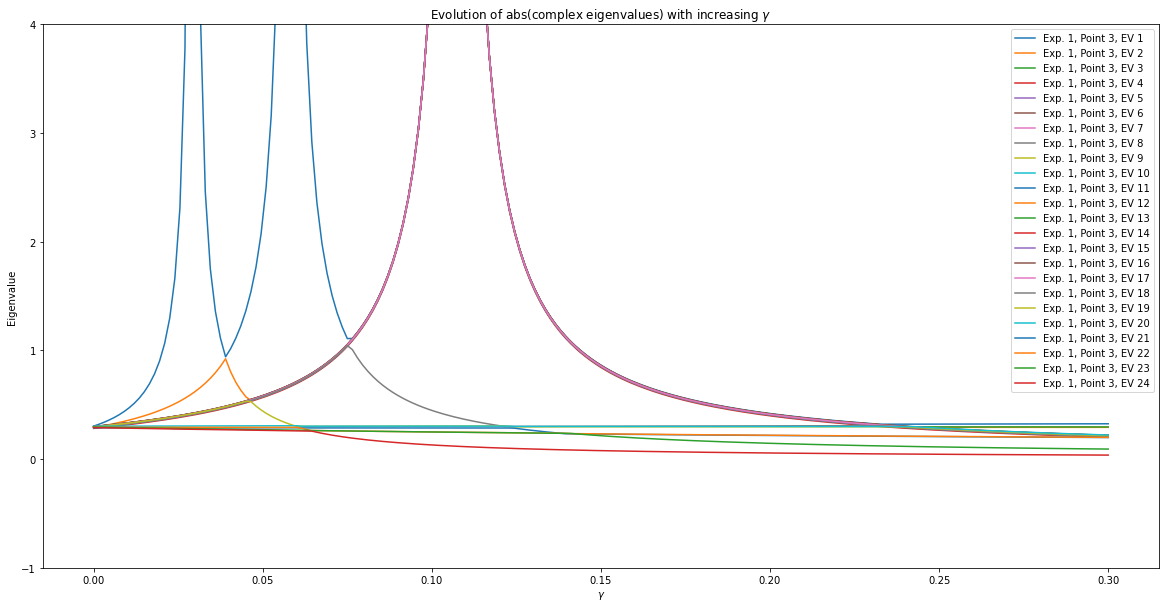

In [48]:
# zoom in
run_and_plot([trans_prime], points_list=real_points_list[:n_points], gammas=np.linspace(0, .3, 201), mark_positive_slope=False, num_evals=24, one_plot_per_point=True)

## Other investigations

### Comparing [**Learned Convolution matrix**, **Random matrix**] one on one, with **real MNIST datapoints**

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 1: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


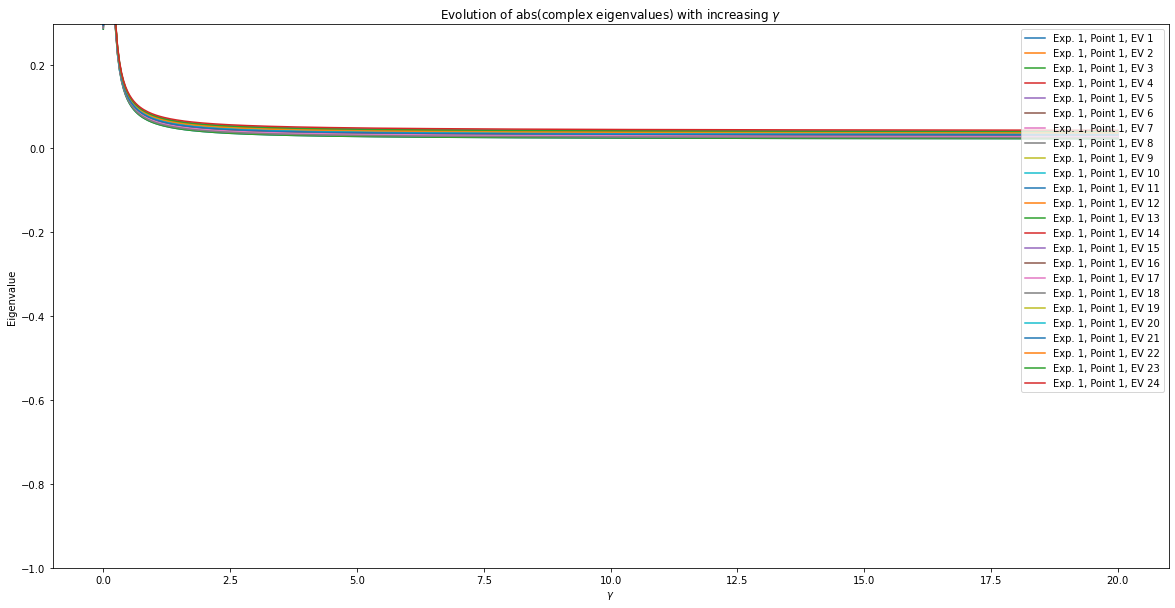

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 2, Point 1: 208 of 208 Eigenvalues are non-zero. 24 get plotted.


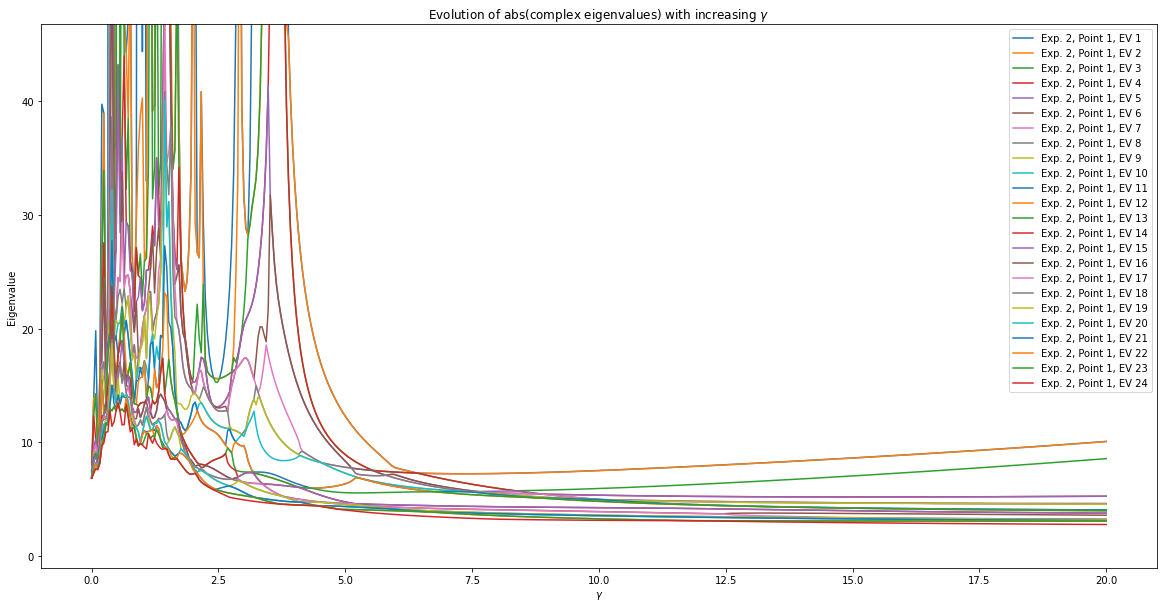

In [49]:
index = 0

run_and_plot([trans_prime, big_random_matrix_w_zeros], 
                [real_points_list[index]], gammas, mark_positive_slope=False, percentile_to_plot=99, num_evals=24)

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 1: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


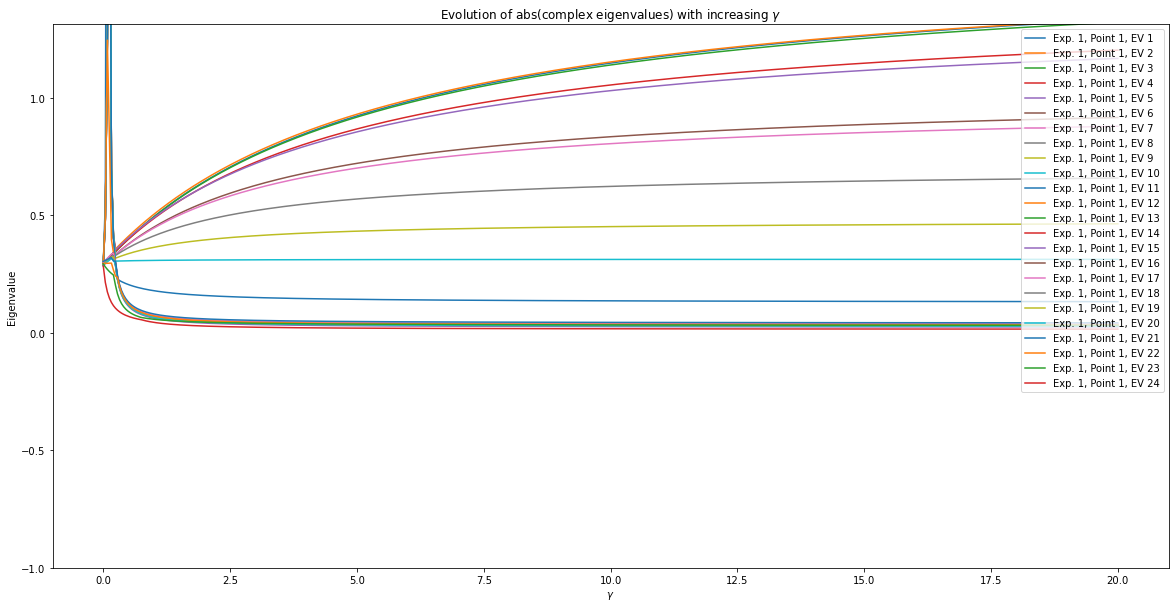

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 2, Point 1: 208 of 208 Eigenvalues are non-zero. 24 get plotted.


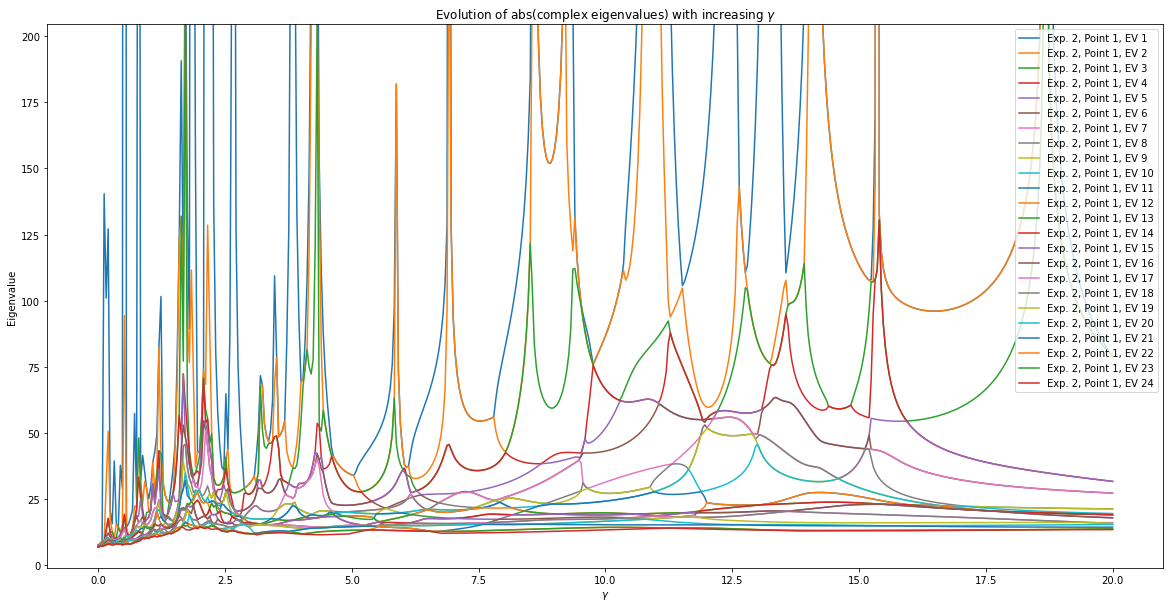

In [50]:
index = 1

run_and_plot([trans_prime, big_random_matrix_w_zeros], 
                [real_points_list[index]], gammas, mark_positive_slope=False, percentile_to_plot=99, num_evals=24)

### Plot outputs for a few Gammas

0
(784,)
(24, 24)


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


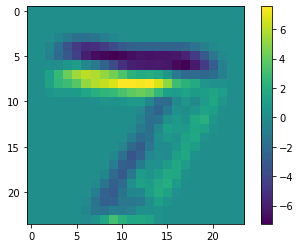

1
(784,)
(24, 24)


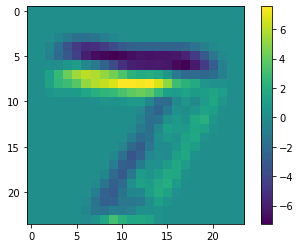

5
(784,)
(24, 24)


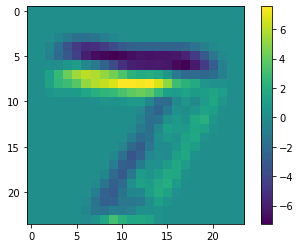

10
(784,)
(24, 24)


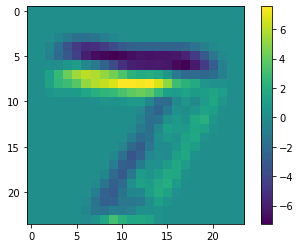

20
(784,)
(24, 24)


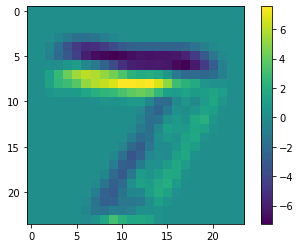

100
(784,)
(24, 24)


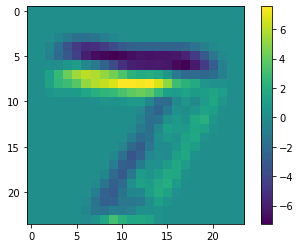

1000
(784,)
(24, 24)


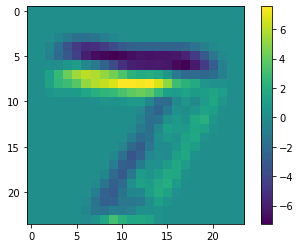

In [51]:
index = 0

for gamma in [0, 1, 5, 10, 20, 100, 1000]:
    print(gamma)
    curr = real_points_list[index]

    mat = forw_surrogate_matrix(trans_prime, curr, gamma)

    out = mat @ curr
    print(out.shape)
    out = out[:576].reshape((24,24))
    print(out.shape)
    plt.colorbar(plt.imshow(out))
    plt.show()
    